# Artificial Neural Networks for Regression

_By: Ling Li Ya, Liana_

## Pre-training Preparation

### Installing Dependencies

In [1]:
!pip install tensorflow
!pip install keras

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

2021-11-30 17:42:15.832664: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-30 17:42:15.832721: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Loading Data

In [3]:
# Cleaned dataset with no outliers
X_train_no = pd.read_csv('../dataset/no_outliers/X_train.csv')
X_test_no = pd.read_csv('../dataset/no_outliers/X_test.csv')
y_train_no = pd.read_csv('../dataset/no_outliers/y_train.csv')
y_test_no = pd.read_csv('../dataset/no_outliers/y_test.csv')

# Uncleaned original data
X_train_with = pd.read_csv('../dataset/with_outliers/X_train.csv')
X_test_with = pd.read_csv('../dataset/with_outliers/X_test.csv')
y_train_with = pd.read_csv('../dataset/with_outliers/y_train.csv')
y_test_with = pd.read_csv('../dataset/with_outliers/y_test.csv')

In [4]:
def standardise_data(X_train, y_train, X_test, y_test):
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    # Scale data to standardise data values
    X_train_trans = X_scaler.fit_transform(X_train)
    y_train_trans = y_scaler.fit_transform(y_train)
    X_test_trans = X_scaler.transform(X_test)
    y_test_trans = y_scaler.transform(y_test)
    
    print(X_train_trans.shape, y_train_trans.shape, X_test_trans.shape, y_test_trans.shape)

    return X_scaler, y_scaler, X_train_trans, y_train_trans, X_test_trans, y_test_trans

X_scaler_no, y_scaler_no, X_train_no_trans, y_train_no_trans, X_test_no_trans, y_test_no_trans = standardise_data(X_train_no, y_train_no, X_test_no, y_test_no)

(578, 9) (578, 1) (145, 9) (145, 1)


## Training

Using a layer with 5 neurons, with 9 input dimensions of normal weight, using relu activation function. Batch size is 20 and training epochs are 50.

In [5]:
def create_seq_model():
    model = Sequential()

    # Defining the input layer and first hidden layer
    model.add(Dense(units=5, input_dim=9, kernel_initializer='normal', activation='relu'))

    # Defining the second layer of the model
    model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))

    # The output neuron is a single fully connected node as only a single number is predicted
    model.add(Dense(1, kernel_initializer='normal'))

    # Compiling the model
    model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

    return model

def train_model(model, X_train, y_train):
    # Fitting the ANN to the training data
    model.fit(X_train, y_train, batch_size=20, epochs=50, verbose=1)

    return model

model_no = create_seq_model()
model_no = train_model(model_no, X_train_no_trans, y_train_no_trans)

2021-11-30 17:42:21.655027: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (100)
2021-11-30 17:42:21.655106: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Liana-ASUS): /proc/driver/nvidia/version does not exist
2021-11-30 17:42:21.655995: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
29/29 [==============================] - 1s 6ms/step - loss: 0.9972 - mse: 0.9972 - mae: 0.8129
Epoch 2/50
29/29 [==============================] - 0s 5ms/step - loss: 0.9790 - mse: 0.9790 - mae: 0.8054
Epoch 3/50
29/29 [==============================] - 0s 3ms/step - loss: 0.9168 - mse: 0.9168 - mae: 0.7791
Epoch 4/50
29/29 [==============================] - 0s 2ms/step - loss: 0.7792 - mse: 0.7792 - mae: 0.7165
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 0.5830 - mse: 0.5830 - mae: 0.6193
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 0.4095 - mse: 0.4095 - mae: 0.5182
Epoch 7/50
29/29 [==============================] - 0s 2ms/step - loss: 0.2983 - mse: 0.2983 - mae: 0.4367
Epoch 8/50
29/29 [==============================] - 0s 2ms/step - loss: 0.2454 - mse: 0.2454 - mae: 0.3878
Epoch 9/50
29/29 [==============================] - 0s 2ms/step - loss: 0.2223 - mse: 0.2223 - mae: 0.3608
Epoch 10/50
29/29 [==================

## Hyperparameter Tuning

To find the best accuracy with the minimum number of layers/neurons.

### Grid Search

Mean Square Error (MSE) is used with the formula `(sum of all (y_true - y_pred)^2)/total number of y_true`

In [6]:
# Find the best parameters for ANN
def find_best_params(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list = [5, 10, 15, 20]
    epoch_list = [5, 10, 50, 100]

    results = pd.DataFrame(columns=['trial_num', 'param', 'accuracy'])
    
    # Initialising the trials
    trial_number = 0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            trial_number += 1
            # Create ANN model
            model = Sequential()

            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

            # Defining the second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))

            # Output neuron
            model.add(Dense(1, kernel_initializer='normal'))

            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')

            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)

            pred = model.predict(X_test)

            MSE = 0
            for i in range(y_test.shape[0]):
                MSE += (y_test[i,0] - pred[i][0])**2

            MSE /= y_test.shape[0]
            
            # Printing the results of the current iteration
            print(trial_number, 'Parameters:','batch_size:', batch_size_trial,'-', 'Epochs:',epochs_trial, 'MSE:', MSE)
            
            results = results.append(pd.DataFrame(data=[[trial_number, str(batch_size_trial)+'-'+str(epochs_trial), MSE]], columns=['trial_num', 'param', 'mse'] ))

    return(results)

results_no = find_best_params(X_train_no_trans, y_train_no_trans, X_test_no_trans, y_test_no_trans)

1 Parameters: batch_size: 5 - Epochs: 5 MSE: 0.19724783797882628
2 Parameters: batch_size: 5 - Epochs: 10 MSE: 0.1614009120629752
3 Parameters: batch_size: 5 - Epochs: 50 MSE: 0.14135062407029314
4 Parameters: batch_size: 5 - Epochs: 100 MSE: 0.11702383681250692
5 Parameters: batch_size: 10 - Epochs: 5 MSE: 0.41614432148456304
6 Parameters: batch_size: 10 - Epochs: 10 MSE: 0.20857683680317574
7 Parameters: batch_size: 10 - Epochs: 50 MSE: 0.13570887727805733
8 Parameters: batch_size: 10 - Epochs: 100 MSE: 0.13338939726211899
9 Parameters: batch_size: 15 - Epochs: 5 MSE: 0.6951336186531647
10 Parameters: batch_size: 15 - Epochs: 10 MSE: 0.2506945254710916
11 Parameters: batch_size: 15 - Epochs: 50 MSE: 0.14543591651100338
12 Parameters: batch_size: 15 - Epochs: 100 MSE: 0.13109650222121746
13 Parameters: batch_size: 20 - Epochs: 5 MSE: 0.8193654647813673
14 Parameters: batch_size: 20 - Epochs: 10 MSE: 0.5590260245581964
15 Parameters: batch_size: 20 - Epochs: 50 MSE: 0.24236319308863344

### Plotting Results

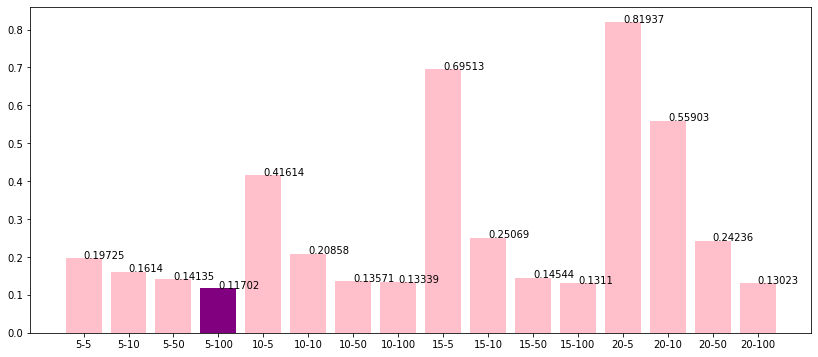

In [7]:
def plot_bar_chart(results):
    plt.figure(figsize=(14,6))
    colors = ['pink' if result != min(results['mse']) else 'purple' for result in results['mse']]
    plt.bar(results['param'], height=results['mse'], color=colors)
    # plt.axhline(y=1.0, color='purple', linestyle='-')
    for a, b in zip([x for x in range(len(results['mse']))], round(results['mse'], 5)):
        plt.text(a, b, str(b), color='black')
    plt.show()

plot_bar_chart(results_no)

For MSE, a lower value is better. From the graph above, it can be known that the best hyperparameters are `batch_size` = 5 and `epochs` = 100.

In [19]:
def evaluate_model(test_data):
    # Sum of squared error
    test_data['SE'] = (test_data['count'] - test_data['pred_count'])**2

    print(test_data.head())

    print("MSE: ", np.mean(test_data['SE']))

In [24]:
# Fine-tune hyperparameters
def fine_tune_model(model, batch_size, epochs, X_scaler, y_scaler, X_train_trans, y_train_trans, X_test_trans, y_test_trans, columns):
    model.fit(X_train_trans, y_train_trans, batch_size=batch_size, epochs=epochs, verbose=0)

    pred = model.predict(X_test_trans)

    test_data_scaled = pd.DataFrame(data=X_test_trans, columns=columns)
    test_data_scaled['count'] = y_test_trans
    test_data_scaled['pred_count'] = pred
    evaluate_model(test_data_scaled)

    # Scale predictions
    pred = y_scaler.inverse_transform(pred)

    # Scale back to original
    y_test = y_scaler.inverse_transform(y_test_trans)
    X_test = X_scaler.inverse_transform(X_test_trans)

    test_data = pd.DataFrame(data=X_test, columns=columns)
    test_data['count'] = y_test
    test_data['pred_count'] = pred
    # print(test_data.head())

    return test_data

test_data_no = fine_tune_model(
        model=model_no,
        batch_size=5,
        epochs=100,
        X_scaler=X_scaler_no,
        y_scaler=y_scaler_no,
        X_train_trans=X_train_no_trans,
        y_train_trans=y_train_no_trans,
        X_test_trans=X_test_no_trans,
        y_test_trans=y_test_no_trans,
        columns=X_test_no.columns
    )

     season      year     month  holiday   weekday   weather  temperature  \
0  0.449189  1.003466  0.147272 -0.16873 -1.505757 -0.736674     1.234309   
1 -0.461798  1.003466 -0.439786 -0.16873  0.493847 -0.736674     0.533490   
2  0.449189  1.003466  0.440802 -0.16873  0.993748  1.090784     1.475494   
3 -0.461798  1.003466 -0.733315 -0.16873  0.993748 -0.736674    -0.504081   
4  1.360175  1.003466  1.321389 -0.16873 -1.005856 -0.736674    -0.963703   

   humidity  windspeed     count  pred_count        SE  
0 -0.028125  -0.246866  1.095397    1.013958  0.006632  
1 -0.761407   0.529099  1.506397    1.453898  0.002756  
2  0.104396   0.349382  1.397250    0.849386  0.300155  
3 -1.771513   1.460496  1.023851    0.445691  0.334268  
4 -0.943989   0.619070  0.396644    0.265340  0.017241  
MSE:  0.11213698541482214


In [10]:
model_no.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 50        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


## Using Data With Outliers

In [11]:
X_scaler_with, y_scaler_with, X_train_with_trans, y_train_with_trans, X_test_with_trans, y_test_with_trans = standardise_data(X_train_with, y_train_with, X_test_with, y_test_with)

(584, 9) (584, 1) (147, 9) (147, 1)


In [12]:
model_with = create_seq_model()
model_with = train_model(model_with, X_train_with_trans, y_train_with_trans)

Epoch 1/50
30/30 [==============================] - 1s 4ms/step - loss: 0.9980 - mse: 0.9980 - mae: 0.8152
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.9853 - mse: 0.9853 - mae: 0.8102
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.9332 - mse: 0.9332 - mae: 0.7887
Epoch 4/50
30/30 [==============================] - 0s 5ms/step - loss: 0.8111 - mse: 0.8111 - mae: 0.7342
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6383 - mse: 0.6383 - mae: 0.6483
Epoch 6/50
30/30 [==============================] - 0s 2ms/step - loss: 0.4765 - mse: 0.4765 - mae: 0.5558
Epoch 7/50
30/30 [==============================] - 0s 2ms/step - loss: 0.3510 - mse: 0.3510 - mae: 0.4678
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.2772 - mse: 0.2772 - mae: 0.4090
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.2372 - mse: 0.2372 - mae: 0.3719
Epoch 10/50
30/30 [==================

The same `batch_size` and `epochs` are used for accuracy comparison.

In [26]:
test_data_with = fine_tune_model(
    model=model_with,
    batch_size=15,
    epochs=10,
    X_scaler=X_scaler_with,
    y_scaler=y_scaler_with,
    X_train_trans=X_train_with_trans,
    y_train_trans=y_train_with_trans,
    X_test_trans=X_test_with_trans,
    y_test_trans=y_test_with_trans,
    columns=X_test_with.columns,
)

     season      year     month   holiday   weekday   weather  temperature  \
0  0.441688 -0.993174  0.131722 -0.167836  1.508537 -0.720359     1.060122   
1  0.441688 -0.993174  0.131722 -0.167836  0.502271 -0.720359     1.404064   
2 -1.362130 -0.993174 -1.603446 -0.167836  1.508537  1.141100    -1.401794   
3 -1.362130 -0.993174 -1.314251 -0.167836 -0.503995  1.141100    -1.625316   
4 -1.362130  1.006873 -1.603446 -0.167836  0.502271  1.141100    -0.813466   

   humidity  windspeed     count  pred_count        SE  
0 -0.276179   0.246691  0.750388    0.249310  0.251079  
1  0.196746  -0.396460  0.050831    0.154996  0.010850  
2 -0.891873  -0.412649 -1.706735   -1.418742  0.082939  
3  1.469644  -1.783575 -1.647869   -1.753354  0.011127  
4  1.041464  -1.519431 -0.220898   -0.283682  0.003942  
MSE:  0.14570633455464452


In [15]:
model_with.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 5)                 50        
                                                                 
 dense_52 (Dense)            (None, 5)                 30        
                                                                 
 dense_53 (Dense)            (None, 1)                 6         
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


In conclusion, using cleaned data without outliers would give a higher accuracy than using data with outliers.